# Risk Assessment Kiva Loans

What is risk? In this case, there is no variable that pertains to repayment status or default rate. However, we can indicate the time it took the loan to be funded as a variable of interest. Longer funding time does not automatically mean it is risky. However, it can indicate a perceived risk or hesitation by lenders. Lenders may be slower to fund borrowers from high-risk or less developed regions. Or their loans descriptions seem less compelling. It is a signal of lender behavior, instead of borrow behavior. For this analysis, I will treat longer funding time as a soft indicator of how attractive or “fundable” a borrower is. I analyzed whether low predicted income groups experience longer funding times and combine it with other variables (e.g., loan amount, sector, repayment interval) to understand funding behavior patterns.

In [33]:
import os
os.chdir('/root/kiva_crowdfunding')

In [87]:
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from src.preprocessing import drop_col, classify_economy, has_female_borrower
from src.merge_worldbank import load_data
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder


## Load Model 

In [88]:
model = joblib.load('random_forest_model.pkl')

## Load Dataset

### Original 

In [89]:
loans = pd.read_csv('data/raw/kiva_loans.csv')
gdppc = load_data('data/raw/gdp_percapita.csv')

# Merge the datasets on 'Country Name'
merged_data = pd.merge(loans, gdppc, left_on='country', right_on='Country Name', how='left')
merged_data.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,tags,borrower_genders,repayment_interval,date,Country Name,Country Code,Indicator Name,Indicator Code,Year,GDP per capita
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,...,NaN,female,irregular,2014-01-01,Pakistan,PAK,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,2023.0,6036.650769
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,...,NaN,"female, female",irregular,2014-01-01,Pakistan,PAK,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,2023.0,6036.650769
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,...,"user_favorite, user_favorite",female,bullet,2014-01-01,India,IND,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,2023.0,10166.243411
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,...,NaN,female,irregular,2014-01-01,Pakistan,PAK,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,2023.0,6036.650769
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,...,NaN,female,monthly,2014-01-01,Pakistan,PAK,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,2023.0,6036.650769


### Featured Data

In [90]:
df = merged_data.drop(columns=['id', 'activity', 'use', 'country_code', 'country', 'region', 'currency',
                    'disbursed_time', 'tags', 'date','Indicator Name', 'Indicator Code', 'Country Code', 'Year', 'partner_id'])

### Preprocessing

In [91]:
# Income
df = classify_economy(df) 
df = df.dropna(subset=['GDP per capita', 'Income Group'])

# Scaling
df['funded_amount_log'] = np.log1p(df['funded_amount'])
df['loan_amount_log'] = np.log1p(df['loan_amount'])

scaler = StandardScaler()
numerical_cols = ['funded_amount_log', 'loan_amount_log']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Onehot Encoding
df = has_female_borrower(df)

categorical_cols = ['sector', 'repayment_interval']

dummies = pd.get_dummies(df[categorical_cols], drop_first=True)

df = pd.concat([df, dummies], axis=1)

label_encoder = LabelEncoder()
df['Income Group'] = label_encoder.fit_transform(df['Income Group'])

In [92]:
feature_cols = joblib.load("feature_columns.pkl")  # if you saved it
X = df[feature_cols]

## Predict Income Group

In [93]:
df["predicted_income_group"] = model.predict(X)

In [94]:
df

,funded_amount,loan_amount,sector,posted_time,funded_time,term_in_months,lender_count,borrower_genders,repayment_interval,Country Name,...,sector_Manufacturing,sector_Personal Use,sector_Retail,sector_Services,sector_Transportation,sector_Wholesale,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly,predicted_income_group
0,300.0,300.0,Food,2014-01-01 06:12:39+00:00,2014-01-02 10:06:32+00:00,12.0,12,female,irregular,Pakistan,...,False,False,False,False,False,False,True,False,False,2
1,575.0,575.0,Transportation,2014-01-01 06:51:08+00:00,2014-01-02 09:17:23+00:00,11.0,14,"female, female",irregular,Pakistan,...,False,False,False,False,True,False,True,False,False,3
2,150.0,150.0,Transportation,2014-01-01 09:58:07+00:00,2014-01-01 16:01:36+00:00,43.0,6,female,bullet,India,...,False,False,False,False,True,False,False,False,False,3
3,200.0,200.0,Arts,2014-01-01 08:03:11+00:00,2014-01-01 13:00:00+00:00,11.0,8,female,irregular,Pakistan,...,False,False,False,False,False,False,True,False,False,3
4,400.0,400.0,Food,2014-01-01 11:53:19+00:00,2014-01-01 19:18:51+00:00,14.0,16,female,monthly,Pakistan,...,False,False,False,False,False,False,False,True,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671200,0.0,25.0,Agriculture,2017-07-25 16:55:34+00:00,NaN,13.0,0,female,monthly,Paraguay,...,False,False,False,False,False,False,False,True,False,3
671201,25.0,25.0,Agriculture,2017-07-25 06:14:08+00:00,2017-07-26 02:09:43+00:00,13.0,1,female,monthly,Kenya,...,False,False,False,False,False,False,False,True,False,3
671202,0.0,25.0,Entertainment,2017-07-26 00:02:07+00:00,NaN,13.0,0,,monthly,Kenya,...,False,False,False,False,False,False,False,True,False,3
671203,0.0,25.0,Agriculture,2017-07-26 06:12:55+00:00,NaN,13.0,0,female,monthly,Kenya,...,False,False,False,False,False,False,False,True,False,3


## Average Loan Amount by Group

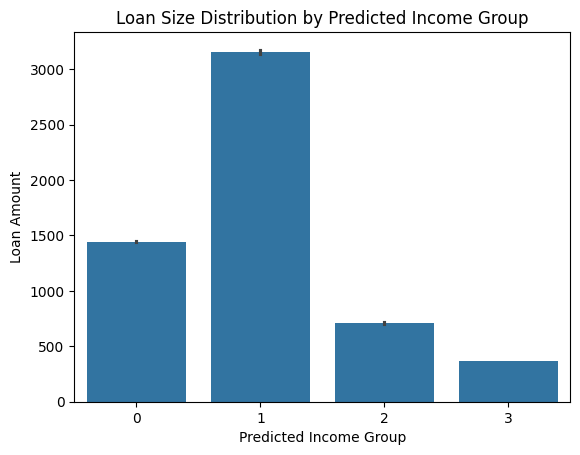

In [95]:
sns.barplot(x="predicted_income_group", y="loan_amount", data=df)
plt.title("Loan Size Distribution by Predicted Income Group")
plt.xlabel("Predicted Income Group")
plt.ylabel("Loan Amount")
plt.show()


## Days to Fund by Group

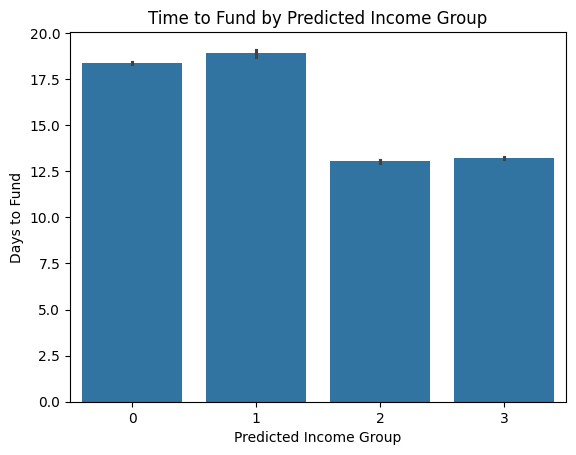

In [96]:
df['funded_time'] = pd.to_datetime(df['funded_time'])
df['posted_time'] = pd.to_datetime(df['posted_time'])
df["funding_time"] = (df['funded_time'] - df['posted_time']).dt.total_seconds() / (3600 * 24)

sns.barplot(x="predicted_income_group", y="funding_time", data=df)
plt.title("Time to Fund by Predicted Income Group")
plt.xlabel("Predicted Income Group")
plt.ylabel("Days to Fund")
plt.show()

Analysis of the funding data reveals that loans associated with borrowers in income groups 0 and 1 consistently experience longer days to fund compared to those in income groups 2 and 3. This suggests that lower-income borrowers may face greater delays in securing funding, potentially reflecting higher perceived risk or reduced lender confidence. Understanding this disparity highlights challenges in financial accessibility for lower-income groups and underscores the need for targeted interventions to improve equitable loan disbursement.

## Sector Breakdown

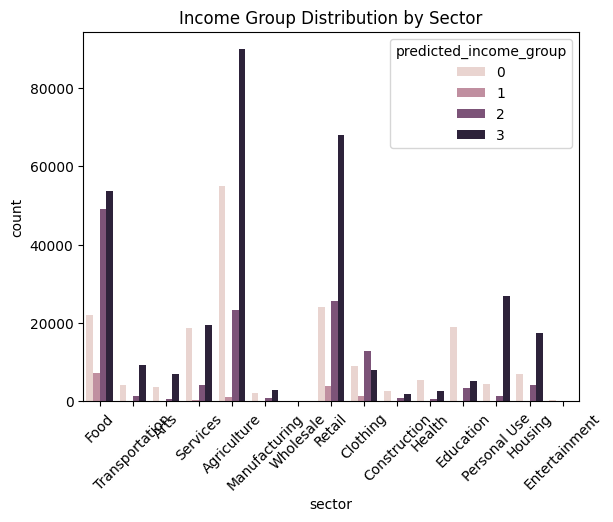

In [100]:
sns.countplot(x="sector", hue="predicted_income_group", data=df)
plt.title("Income Group Distribution by Sector")
plt.xticks(rotation=45)
plt.show()